<a href="https://colab.research.google.com/github/scw1998/projects/blob/main/UOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NAME: 서치원

## Introduction
The dataset spans from January 1, 2018, to December 31, 2021, and includes daily rental data for four districts: Gwangjin-gu, Dongdaemun-gu, Seongdong-gu, and Jungnang-gu. Each district's data is recorded in thousands of rentals per day. I will use LSTM  

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


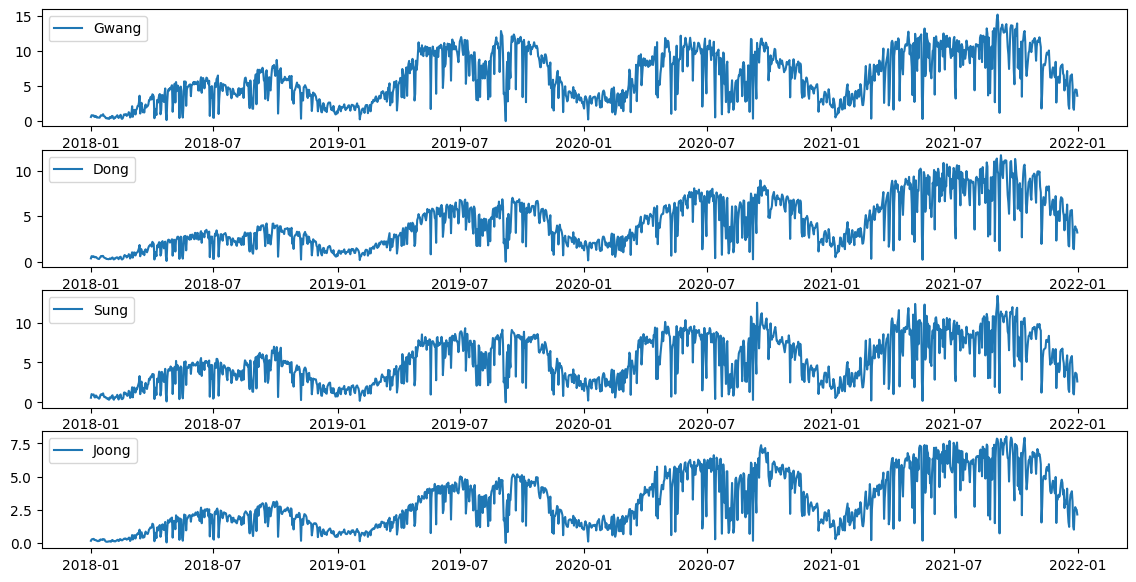

torch.Size([1138, 30, 4]) torch.Size([1138, 4]) torch.Size([263, 30, 4]) torch.Size([263, 4])
cpu is available
Epoch [10/200], Loss: 0.0150
Epoch [20/200], Loss: 0.0153
Epoch [30/200], Loss: 0.0151
Epoch [40/200], Loss: 0.0142
Epoch [50/200], Loss: 0.0141
Epoch [60/200], Loss: 0.0139
Epoch [70/200], Loss: 0.0137
Epoch [80/200], Loss: 0.0131
Epoch [90/200], Loss: 0.0130
Epoch [100/200], Loss: 0.0119
Epoch [110/200], Loss: 0.0108
Epoch [120/200], Loss: 0.0104
Epoch [130/200], Loss: 0.0108
Epoch [140/200], Loss: 0.0084
Epoch [150/200], Loss: 0.0101
Epoch [160/200], Loss: 0.0131
Epoch [170/200], Loss: 0.0062
Epoch [180/200], Loss: 0.0083
Epoch [190/200], Loss: 0.0031
Epoch [200/200], Loss: 0.0056


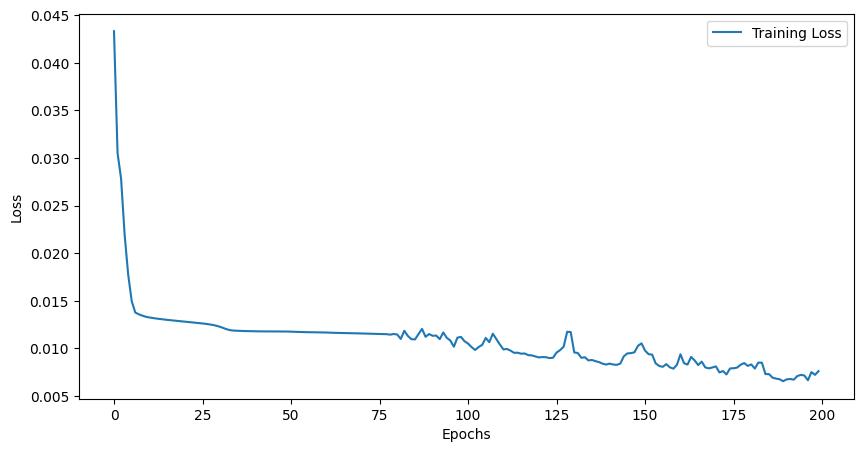

Train RMSE: 1.0893, Train NMAPE: 5.753983295519531
Test RMSE: 2.4476, Test NMAPE: 11.835296902209127


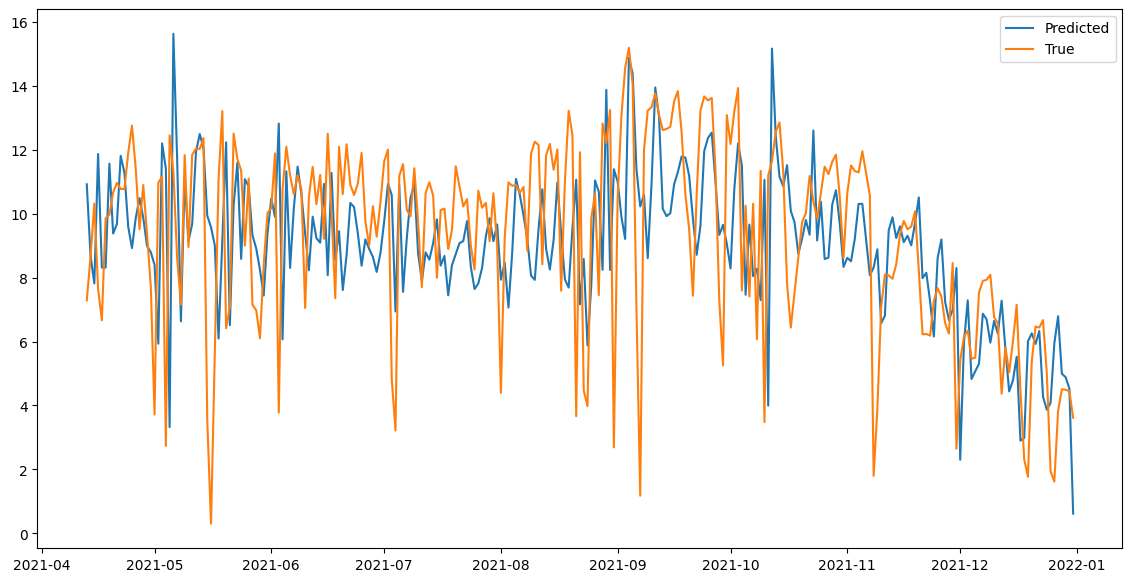

In [11]:
# Load the data
data = pd.read_csv("train.csv")

# Convert the date column to datetime format
data['일시'] = pd.to_datetime(data['일시'], format='%Y%m%d')

# Set the date column as the index
data.set_index('일시', inplace=True)

#Rename the column names
data.index.names = ['Date']
data.columns = ["Gwang","Dong",'Sung',"Joong"] #광진구	동대문구	성동구	중랑구

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data

# Plot the data to visualize the time series
plt.figure(figsize=(14, 7))
for i, col in enumerate(data.columns):
    plt.subplot(len(data.columns), 1, i+1)
    plt.plot(data.index, data[col], label=col)
    plt.legend(loc='upper left')
plt.show()

# Transform the time series data into a suitable format for training the LSTM model
def create_sequences(data, seq_length):
    x_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        #print(x,"->",y)
        x_seq.append(x)
        y_seq.append(y)
    return np.array(x_seq), np.array(y_seq)

# Split the data into training and testing sets
split_ratio = 0.8
train_size = int(len(scaled_data) * split_ratio)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Define sequence length
seq_length = 30

# Create sequences
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Display the shapes of the datasets
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Define the LSTM model (Extension of RNN)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # RNN으로 하고 싶으시면, 이 line지우시면 됩니다.
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:, -1, :])
        return out

# Set device, hyperparameters, and initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

input_size = X_train.shape[2] #4
hidden_size = 64
num_layers = 2
output_size = y_train.shape[1] #4
num_epochs = 200
learning_rate = 0.001

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_graph = []
# Train the model
model.train() # Set the model to training mode
for epoch in range(num_epochs):
  running_loss = 0.0 # Initialize running loss for the current epoch
  for i in train_loader:
    seq, target = i
    out = model(seq)
    loss = criterion(out, target)
    optimizer.zero_grad() # Clear the gradients of all optimized tensors
    loss.backward() # compute gradient of the loss with respect to model parameters
    optimizer.step()  #Perform a single optimization step
    running_loss += loss.item()
  loss_graph.append(running_loss / len(train_loader))
  if (epoch + 1) % 10 == 0: # Print the loss every 10 epochs
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}') # Print the current epoch and loss

# Plot the loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), loss_graph, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    train_predictions = model(X_train.to(device)).cpu().numpy()
    test_predictions = model(X_test.to(device)).cpu().numpy()

# Inverse transform the predictions and true values
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calculate RMSE Lower the RMSE, the lower, the better
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Calculate NMAPE, the lower, the better
def nmape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (np.max(y_true) - np.min(y_true)))) * 100

train_nmape = nmape(y_train, train_predictions)
test_nmape = nmape(y_test, test_predictions)

print(f'Train RMSE: {train_rmse:.4f}, Train NMAPE: {train_nmape}')
print(f'Test RMSE: {test_rmse:.4f}, Test NMAPE: {test_nmape}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(test_predictions):], test_predictions[:, 0], label='Predicted')
plt.plot(data.index[-len(test_predictions):], y_test[:, 0], label='True')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44305 (\N{HANGUL SYLLABLE GWANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


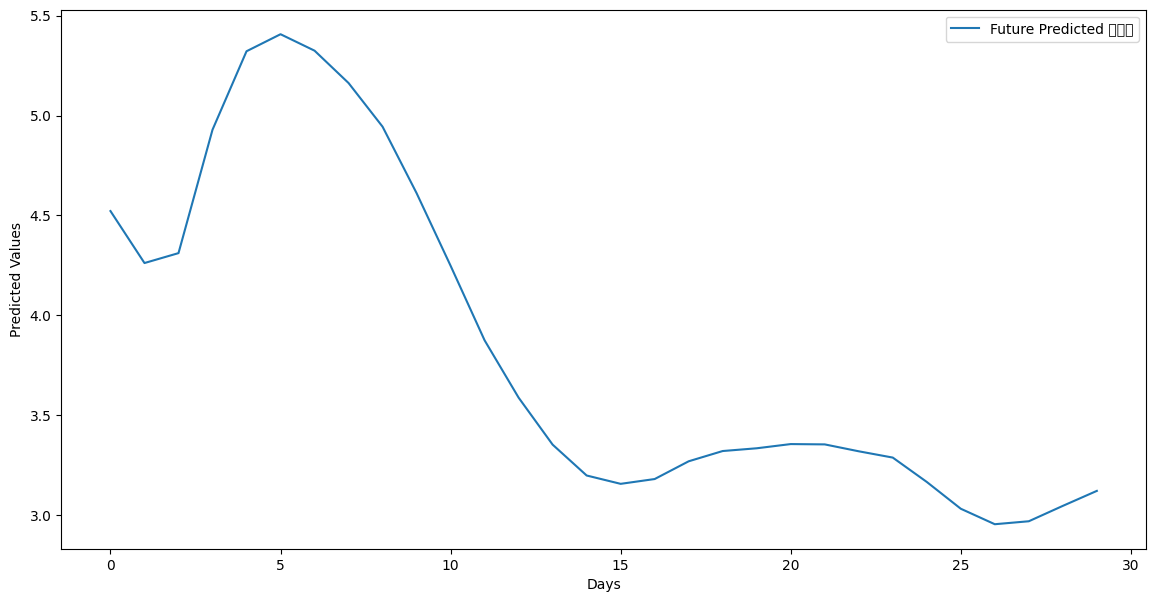

Total rentals for the next 30 days: [114.935425  72.79376   98.66538   50.181305]


In [15]:
# Forecasting future values
future_steps = 30  # Number of days to forecast
last_sequence = X_test[-1].unsqueeze(0).to(device)
future_predictions = []

model.eval()
for _ in range(future_steps):
    with torch.no_grad():
        future_pred = model(last_sequence)
        future_predictions.append(future_pred.cpu().numpy())
        # Update last_sequence by removing the first time step and adding the new prediction
        last_sequence = torch.cat((last_sequence[:, 1:, :], future_pred.unsqueeze(1)), dim=1)

future_predictions = np.array(future_predictions).reshape(-1, output_size)
future_predictions = scaler.inverse_transform(future_predictions)

# Plot the future predictionsdd
plt.figure(figsize=(14, 7))
plt.plot(range(future_steps), future_predictions[:, 0], label='Future Predicted')
plt.xlabel('Days')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Calculate the total rentals for the forecasted period
total_rentals = np.sum(future_predictions, axis=0)
print(f'Total rentals for the next {future_steps} days: {total_rentals}')